In [1]:
# # This Python 3 environment comes with many helpful analytics libraries installed
# # It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# # For example, here's several helpful packages to load

# import numpy as np # linear algebra
# import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# # Input data files are available in the read-only "../input/" directory
# # For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

# import os

# for dirname, _, filenames in os.walk('/kaggle/input'):
#     for filename in filenames:
#         print(os.path.join(dirname, filename))
#         break
# # You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# # You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [2]:
!git clone https://github.com/sunny1401/experiments_cv_nlp.git


Cloning into 'experiments_cv_nlp'...
remote: Enumerating objects: 632, done.
remote: Counting objects: 100% (263/263), done.
remote: Compressing objects: 100% (196/196), done.
remote: Total 632 (delta 123), reused 160 (delta 67), pack-reused 369
Receiving objects: 100% (632/632), 2.21 MiB | 2.20 MiB/s, done.
Resolving deltas: 100% (318/318), done.


In [3]:
!pip install python-gdcm pylibjpeg pylibjpeg-libjpeg 

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.0/13.0 MB 14.4 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.3/4.3 MB 17.9 MB/s eta 0:00:0000:0100:01


In [4]:
import sys
sys.path.append("experiments_cv_nlp")

In [5]:
import numpy as np
import torch
import os
from src.cv.pytorch.datasets.breast_cancer_detection.dataset import BreastCancerDataset
from src.cv.pytorch.datasets.breast_cancer_detection.transforms import (
    Denoiser, HistogramEqualization, Resize
)


In [6]:
train_images = "/kaggle/input/rsna-breast-cancer-detection/train_images"
test_images = "/kaggle/input/rsna-breast-cancer-detection/test_images"

annotation_train = "/kaggle/input/rsna-breast-cancer-detection/train.csv"
annotation_test= "/kaggle/input/rsna-breast-cancer-detection/test.csv"

In [7]:
from torchvision import transforms

data_transforms = transforms.Compose([
    Resize(size=(512,512),lateral_crop=False),
    HistogramEqualization(),
    Resize(size=512,lateral_crop=True),
    Denoiser(kernel_size=5, blur_type="possion"),
    
])

In [8]:
bcd_train = BreastCancerDataset(
    annotation_file="/kaggle/input/rsna-breast-cancer-detection/train.csv", 
    img_dir= train_images, 
    composed_transforms=data_transforms,
)

In [9]:
bcd_test = BreastCancerDataset(
    annotation_file="/kaggle/input/rsna-breast-cancer-detection/test.csv", 
    img_dir= test_images, 
    composed_transforms=data_transforms,
)

In [10]:
from src.cv.pytorch.datasets.breast_cancer_detection.utils import show_all_pictures_for_a_patient

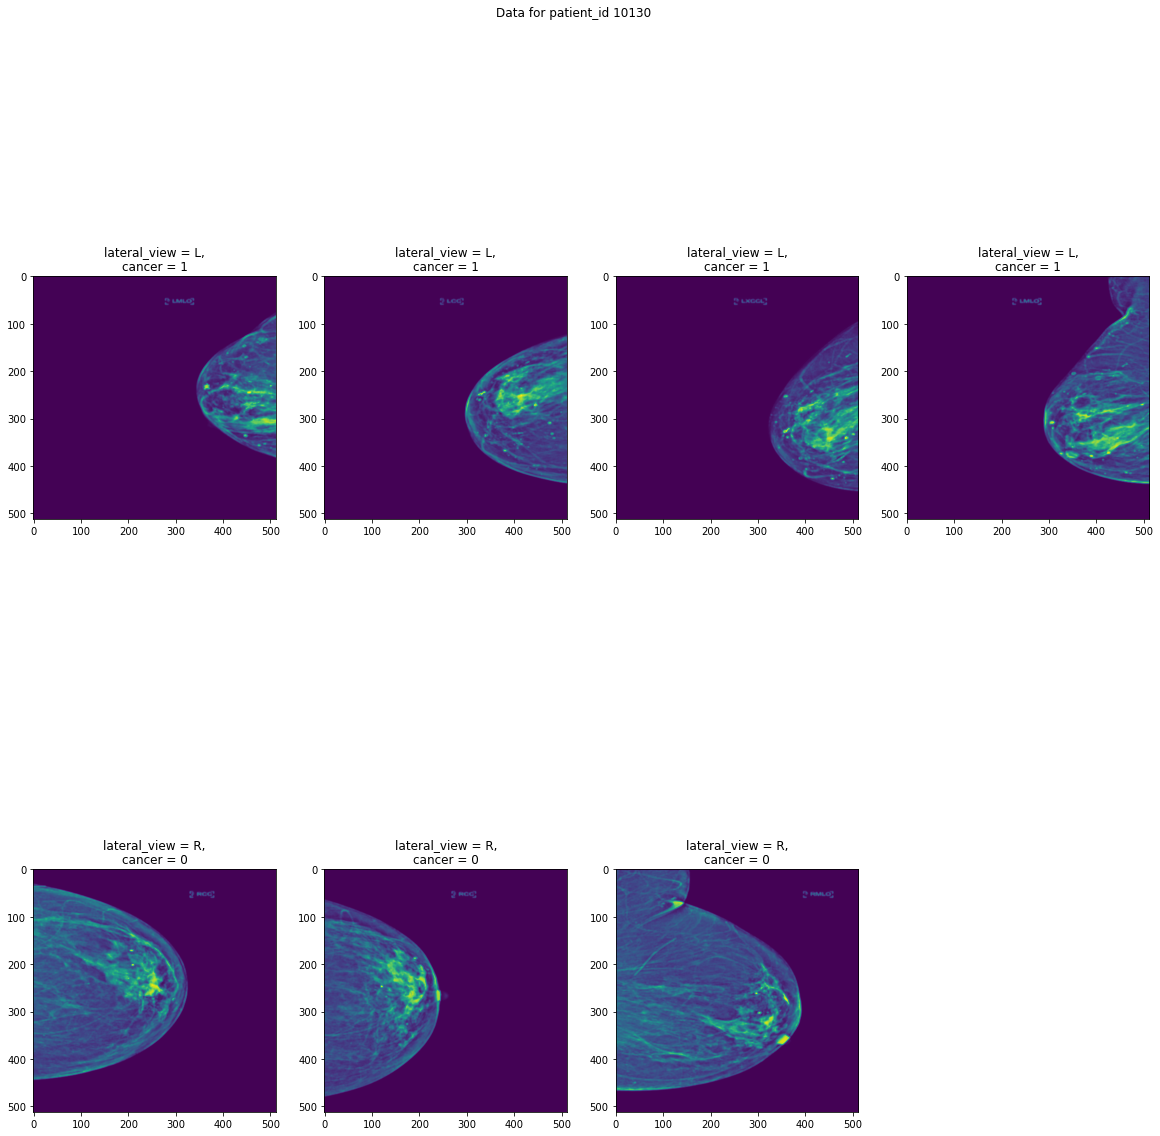

In [11]:
show_all_pictures_for_a_patient(bcd_train, 87)

In [12]:
# Initial config for training
model_training_config = dict(
    learning_rate=0.02,
    batch_size=25,
    epochs=100,
    batch_norm_momentum=0.5
)
model_data_config = dict(
     dataset_size=len(bcd_train), train_data_pct=0.7, model_save_path="bcd_no_weight_resnet"
)

In [13]:
from src.cv.pytorch.models.resnet_model_architectures import RESNET_MODEL_ARCHITECTURES

In [14]:
from src.cv.model_pipelines.dl_base_pipeline import CNNTrainingPipeline
from src.cv.pytorch.models.resnet import VanillaResnet
from typing import Dict, Optional, List
import numpy as np
from torch.utils.data import Dataset
import torch
import torch.nn as nn
import torch.optim as optim
import sys


class BreastCancerTrainingPipeline(CNNTrainingPipeline):

    # Doctring generated by chatGPT
    """
    A pipeline to train BreastCancerDetection model on a facial keypoint detection dataset.
    Parameters:
        dataset (Dataset): The dataset to be used for training and validation.
        model_training_config (Dict): A dictionary containing the training configuration such as number of epochs, batch size etc.
        model_data_config (Dict): A dictionary containing the data configuration such as data preprocessing options.
        model_initialization_params (Dict): A dictionary containing the parameters to initialize the model.
        load_model_from_path (str, optional): The path to the checkpoint file containing a pre-trained model to be loaded.

    Methods:
        initialize_optimization_parameters(lr: float) -> Dict: Initializes the optimizer and criterion to be used for training.
        _initialize_model(device: str, model_params: Dict) -> torch.nn.Module: Initializes the model with the given parameters.
        _fit_model() -> float: Trains the model on the training data and returns the training loss.
        _validate_model() -> float: Validates the model on the validation data and returns the validation loss.
        get_predictions(test_dataloader: DataLoader, device: str) -> List: Makes predictions on the test data and returns a list of predictions.
    """

    def __init__(self, 
        dataset: Dataset, 
        model_training_config: Dict, 
        model_data_config: Dict, 
        model_initialization_params: Dict,
        load_model_from_path: Optional[str] = None
    ):
          super().__init__(
            dataset=dataset, 
            model_training_config=model_training_config, 
            model_data_config=model_data_config, 
            model_initialization_params=model_initialization_params,
            load_model_from_path=load_model_from_path
        )

    def initialize_optimization_parameters(self, lr=0.0005, weights = None) -> Dict:
        criterion = nn.BCEWithLogitsLoss(weights)
        optimizer = optim.Adam(
            self.model.parameters(), lr=lr
        )
        
        return optimizer, criterion

    def _initialize_model(self, device, model_params):

        other_required_keys = dict(
            dropout_threshold=0.09,
            num_linear_layers=1,
            output_channels=None,
            add_dropout_to_linear_layers=True
        
        )
        wraping_layers_map = {}
        for key, value in other_required_keys.items():
            wraping_layers_map[key] = model_params.pop(key, value)

        model = VanillaResnet(**model_params).to(device)
        model.wrap_up_network(**wraping_layers_map)
        return model

    def _generate_train_validation_indices(self, train_on_full_dataset: bool = False):
        columns_required = ["image_id", "patient_id", "laterality", "cancer"]
        df = self.dataset.dataset.image_labels[columns_required]
        if not train_on_full_dataset and self.model_data_config.train_data_pct < 1:
            test_pct = 1 - self.model_data_config.train_data_pct

            df["patient_id"] = df.apply(
                lambda row: f"{row['patient_id']}_{row['laterality']}", axis=1).drop(columns=["laterality"])

            num_cancer_val_ids = round(df[df.cancer == 1]["patient_id"].nunique() * test_pct)
            num_ncancer_val_ids = round(df[df.cancer == 0]["patient_id"].nunique() * test_pct)
            cancer_val_ids = list(np.random.choice(df[df.cancer == 1]["patient_id"].unique(), num_cancer_val_ids))
            num_ncancer_val_ids = list(np.random.choice(df[df.cancer == 0]["patient_id"].unique(), num_ncancer_val_ids))

            val_ids = cancer_val_ids + num_ncancer_val_ids
            train_ids = [patient_id for patient_id in df.patient_id.unique() if patient_id not in val_ids]
            val_indices = df[df.patient_id.isin(val_ids)].index
            train_indices = df[df.patient_id.isin(train_ids)].index

        else:
            train_indices = df.index.tolist()
            val_indices = None

        return train_indices, val_indices

    def _fit_model(self):
        self.model.train()
        batch_training_loss: float = 0

        for idx, data in enumerate(self._train_dataloader):
            image = data["image"]
            label = data["label"]
            # convert variables to floats for regression loss
            label = label.type(torch.FloatTensor)
            image = image.type(torch.FloatTensor)
    #         # inp is shape (N, C, H, W)
            image = image.reshape(image.shape[0], image.shape[-1], image.shape[1], image.shape[2])
            image = image.to(self.model_training_config.device)
            label = label.to(self.model_training_config.device)
            self.optimizer.zero_grad()
            outputs = self.model(image)
            loss = self.criterion(
                outputs, 
                label.reshape(label.shape[0], 1)
            )

            batch_training_loss += loss.item()
            loss.backward()
            self.optimizer.step()

        train_loss = batch_training_loss/ (idx +1)
        return train_loss

    def _validate_model(self):
        batch_validation_loss: float = 0
        self.model.eval()
        with torch.no_grad():

            for idx, data in enumerate(self._validation_dataloader):
                image = data["image"]
                label = data["label"]
                # convert variables to floats for regression loss
                label = label.type(torch.FloatTensor)
                image = image.type(torch.FloatTensor)
                image = image.reshape(image.shape[0], image.shape[-1], image.shape[1], image.shape[2])
                image = image.to(self.model_training_config.device)
                label = label.to(self.model_training_config.device)
                outputs = self.model(image)
                loss = self.criterion(
                    outputs, 
                    label.reshape(label.shape[0], 1)
                )
                batch_validation_loss += loss.item()

        validation_loss = batch_validation_loss/idx + 1
        if min_validation_loss > validation_loss:
            min_validation_loss = validation_loss
            self._final_trained_model = self.model
        return validation_loss,

    def get_predictions(self, test_dataloader: List) -> List:

        model = self.best_model
        model.eval()

        output_keyp = []
        for data in test_dataloader:
            image = data.type(torch.FloatTensor)
            image = image.type(torch.FloatTensor)
            image = image.reshape(image.shape[0], image.shape[-1], image.shape[1], image.shape[2])
            image = image.to(self.model_training_config.device)
            outputs = model(image)
            if self.model_training_config.device == "cuda":
                outputs = outputs.cpu().data.numpy()
            output_keyp.append(outputs)

        return [preds.cpu().detach().numpy() for batch in output_keyp for preds in batch]

    def generate_test_dataloader_from_dataset(self, dataset: Dataset) -> List:

        dataloader = []
        index = 0
        dataset_finished = False
        current_end = self.model_training_config.batch_size
        while(current_end <= len(dataset)):
            dataloader.append(torch.from_numpy(np.array(
                [dataset[j]["image"] for j in range(index, current_end)]
            )))
            if dataset_finished:
                break
            index = current_end
            current_end += self.model_training_config.batch_size
            if current_end > len(dataset):
                current_end = len(dataset)
                dataset_finished = True

        return dataloader

    from src.cv.model_pipelines.breast_cancer_detection_pipeline import BreastCancerTrainingPipeline

In [15]:
model_initialization_params=dict(
        in_channels=1, 
        num_classes=1, 
        initialize_cnn=True, 
        resnet_stride_output_combination=RESNET_MODEL_ARCHITECTURES["resnet18"]
)

In [16]:
bcd_pipeline = BreastCancerTrainingPipeline(
    dataset=bcd_train, 
    model_training_config=model_training_config, 
    model_data_config=model_data_config, 
    model_initialization_params=model_initialization_params
)

In [17]:
bcd_pipeline.model

VanillaResnet(
  (maxPool2d1): MaxPool2d(kernel_size=(3, 3), stride=2, padding=1, dilation=1, ceil_mode=False)
  (conv1): Sequential(
    (0): Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): LeakyReLU(negative_slope=0.1)
    (3): MaxPool2d(kernel_size=(3, 3), stride=2, padding=1, dilation=1, ceil_mode=False)
  )
  (BasicBlock_conv2x_1): ResnetBasicBlock(
    (conv1): Sequential(
      (0): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): LeakyReLU(negative_slope=0.001)
    )
    (conv2): Sequential(
      (0): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
  )
  (BasicBlock_conv2x_2): ResnetBasicBlock(
    (conv1): Sequential(
      (0): Conv

In [ ]:
bcd_pipeline.train()

  0%|          | 0/100 [00:00<?, ?it/s]

In [94]:
import pandas as pd
train_df = pd.read_csv("/kaggle/input/rsna-breast-cancer-detection/train.csv")
test_df = pd.read_csv("/kaggle/input/rsna-breast-cancer-detection/test.csv")

In [ ]:
import numpy as np
random_seed = 0
np.random.seed(random_seed)

In [ ]:

dict_view_map = {view: i for i, view in enumerate(list(train_df.view.unique()))}
dict_laterality_map = {laterality: i for i, laterality in enumerate(list(train_df.laterality.unique()))}
train_df.view = train_df.view.apply(lambda d: dict_view_map[d])
train_df.laterality = train_df.laterality.apply(lambda d: dict_laterality_map[d])

In [ ]:
train_df["id"] = train_df.apply(lambda row: f'{row["patient_id"]}_{row["image_id"]}', axis=1)
train_df.set_index("id", drop=True, inplace=True)

In [ ]:
train_df.loc[train_df.age.isna(), "age"] = train_df.age.mean()

In [ ]:
def get_train_test_patient_ids(train_df, test_pct=0.3):
    
    cancer_patients = list(train_df[train_df.cancer == 1].patient_id.unique())
    non_cancer_patients = list(train_df[train_df.cancer == 0].patient_id.unique())
    
    non_cancer_train_p = int(
        np.floor(len(non_cancer_patients) * (1-test_pct)))
    non_cancer_test_p = len(non_cancer_patients) - non_cancer_train_p
    
    train_ncancer_patients = list(np.random.choice(non_cancer_patients, size=non_cancer_train_p))
    test_ncancer_patients = list(set(non_cancer_patients) - set(train_ncancer_patients))
    
    cancer_train_p = int(np.floor(len(cancer_patients) * (1-test_pct)))
    cancer_test_p = len(cancer_patients) - cancer_train_p
    
    train_cancer_patients = list(np.random.choice(cancer_patients, size=cancer_train_p))
    test_cancer_patients = list(set(cancer_patients) - set(train_cancer_patients))
    
    train_patients = train_cancer_patients + train_ncancer_patients
    test_patients = test_cancer_patients + test_ncancer_patients
    
    val_df = train_df[train_df.patient_id.isin(list(test_patients))].reset_index(drop=True)
    train_df = train_df[train_df.patient_id.isin(list(train_patients))].reset_index(drop=True)
    return train_df, val_df
    

In [ ]:
trn_df, val_df = get_train_test_patient_ids(train_df)

In [ ]:
columns_to_remove = [column for column in train_df.columns if (column not in  {"cancer", "id"} and column not in test_df.columns)]
columns_to_remove += ["site_id", "patient_id", "image_id"]
trn_df.drop(columns=columns_to_remove, inplace=True)
val_df.drop(columns=columns_to_remove, inplace=True)

In [ ]:
y_train = trn_df.pop("cancer")
x_train = trn_df

y_val = val_df.pop("cancer")
x_val = val_df

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score

In [ ]:
model1 = LogisticRegression(
    verbose=True, 
    random_state=random_seed, 
    solver="newton-cg",
    class_weight="balanced",
    penalty="l2",
    C=0.5
)

model1 = model1.fit(x_train, y_train)
preds = model1.predict(x_train)
print("Model inherent f1-score on training_data: ",f1_score(y_train, preds))

print("Model inherent score on training_data: ", model1.score(x_train, y_train))

In [ ]:
ratio = train_df[train_df.cancer == 1].patient_id.nunique()/train_df.patient_id.nunique()

In [ ]:
train_df[train_df.cancer == 0].patient_id.nunique()*ratio